In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from pysal.model import spreg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from pysal.explore import esda
from splot import esda as esdaplot
from pysal.lib import weights
import missingno as msno

/root/venv/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)
/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load the data
data = pd.read_csv('/work/Data/Predictors/ssml_data.csv')
gdf = gpd.read_file('/work/municipalities.shp')

In [4]:
data.head()

,Code,ExperiencedHealthGoodVeryGood,OneOrMorePhysicalLimitations,LimitationInMovement,Underweight,NormalWeight,Overweight,SatisfiesPhysicalActivityGuidelines,WeeklySportsParticipant,Smokers,...,RestWithin5Km,DistanceToAccessMainRoad,DistanceToTrainStationsTotal,DistanceToImportantTransferStation,Gemeentenaam,ProvinciecodePV,Provincienaam,Population,DensityPerKM,CarsPer1000
0,GM1680,83.1,13.8,8.2,0.7,50.1,49.2,47.3,48.3,14.3,...,10.6,1.6,12.5,28.6,Aa en Hunze,PV22,Drenthe,25445.0,92.0,576.0
1,GM0358,82.7,10.2,5.8,1.2,50.3,48.5,48.1,58.8,13.0,...,36.0,1.1,8.1,8.9,Aalsmeer,PV27,Noord-Holland,31859.0,1584.0,532.0
2,GM0197,79.1,15.1,8.3,1.4,49.2,49.4,56.2,51.5,14.7,...,11.6,1.0,4.4,41.0,Aalten,PV25,Gelderland,27121.0,281.0,527.0
3,GM0059,79.1,16.0,11.4,0.8,42.6,56.6,48.7,40.7,19.8,...,6.0,1.3,7.3,26.8,Achtkarspelen,PV21,Friesland,27843.0,272.0,529.0
4,GM0482,77.0,17.1,11.5,2.0,41.7,56.3,42.9,40.0,14.9,...,17.5,2.3,8.5,11.2,Alblasserdam,PV28,Zuid-Holland,20165.0,2297.0,454.0


In [5]:
data.columns

Index(['Code', 'ExperiencedHealthGoodVeryGood', 'OneOrMorePhysicalLimitations',
       'LimitationInMovement', 'Underweight', 'NormalWeight', 'Overweight',
       'SatisfiesPhysicalActivityGuidelines', 'WeeklySportsParticipant',
       'Smokers', 'ExcessiveDrinker', 'DistanceToGP', 'GPWithin5Km',
       'DistanceToLargeSupermarket', 'SMWithin5Km',
       'DistanceToDepartmentStore', 'DSWithin20Km', 'DistanceToCafe',
       'CafeWithin5Km_35', 'DistanceToSnackBar', 'SBWithin5Km',
       'DistanceToRestaurant', 'RestWithin5Km', 'DistanceToAccessMainRoad',
       'DistanceToTrainStationsTotal', 'DistanceToImportantTransferStation',
       'Gemeentenaam', 'ProvinciecodePV', 'Provincienaam', 'Population',
       'DensityPerKM', 'CarsPer1000'],
      dtype='object')

In [6]:
gdf.columns

Index(['Code', 'Experience', 'OneOrMoreP', 'Limitation', 'Underweigh',
       'NormalWeig', 'Overweight', 'SatisfiesP', 'WeeklySpor', 'Smokers',
       'ExcessiveD', 'DistanceTo', 'GPWithin5K', 'Distance_1', 'SMWithin5K',
       'Distance_2', 'DSWithin20', 'Distance_3', 'CafeWithin', 'Distance_4',
       'SBWithin5K', 'Distance_5', 'RestWithin', 'Distance_6', 'Distance_7',
       'Distance_8', 'Gemeentena', 'Provinciec', 'Provincien', 'Population',
       'DensityPer', 'CarsPer100', 'Greenindic', 'geometry'],
      dtype='object')

<AxesSubplot: >

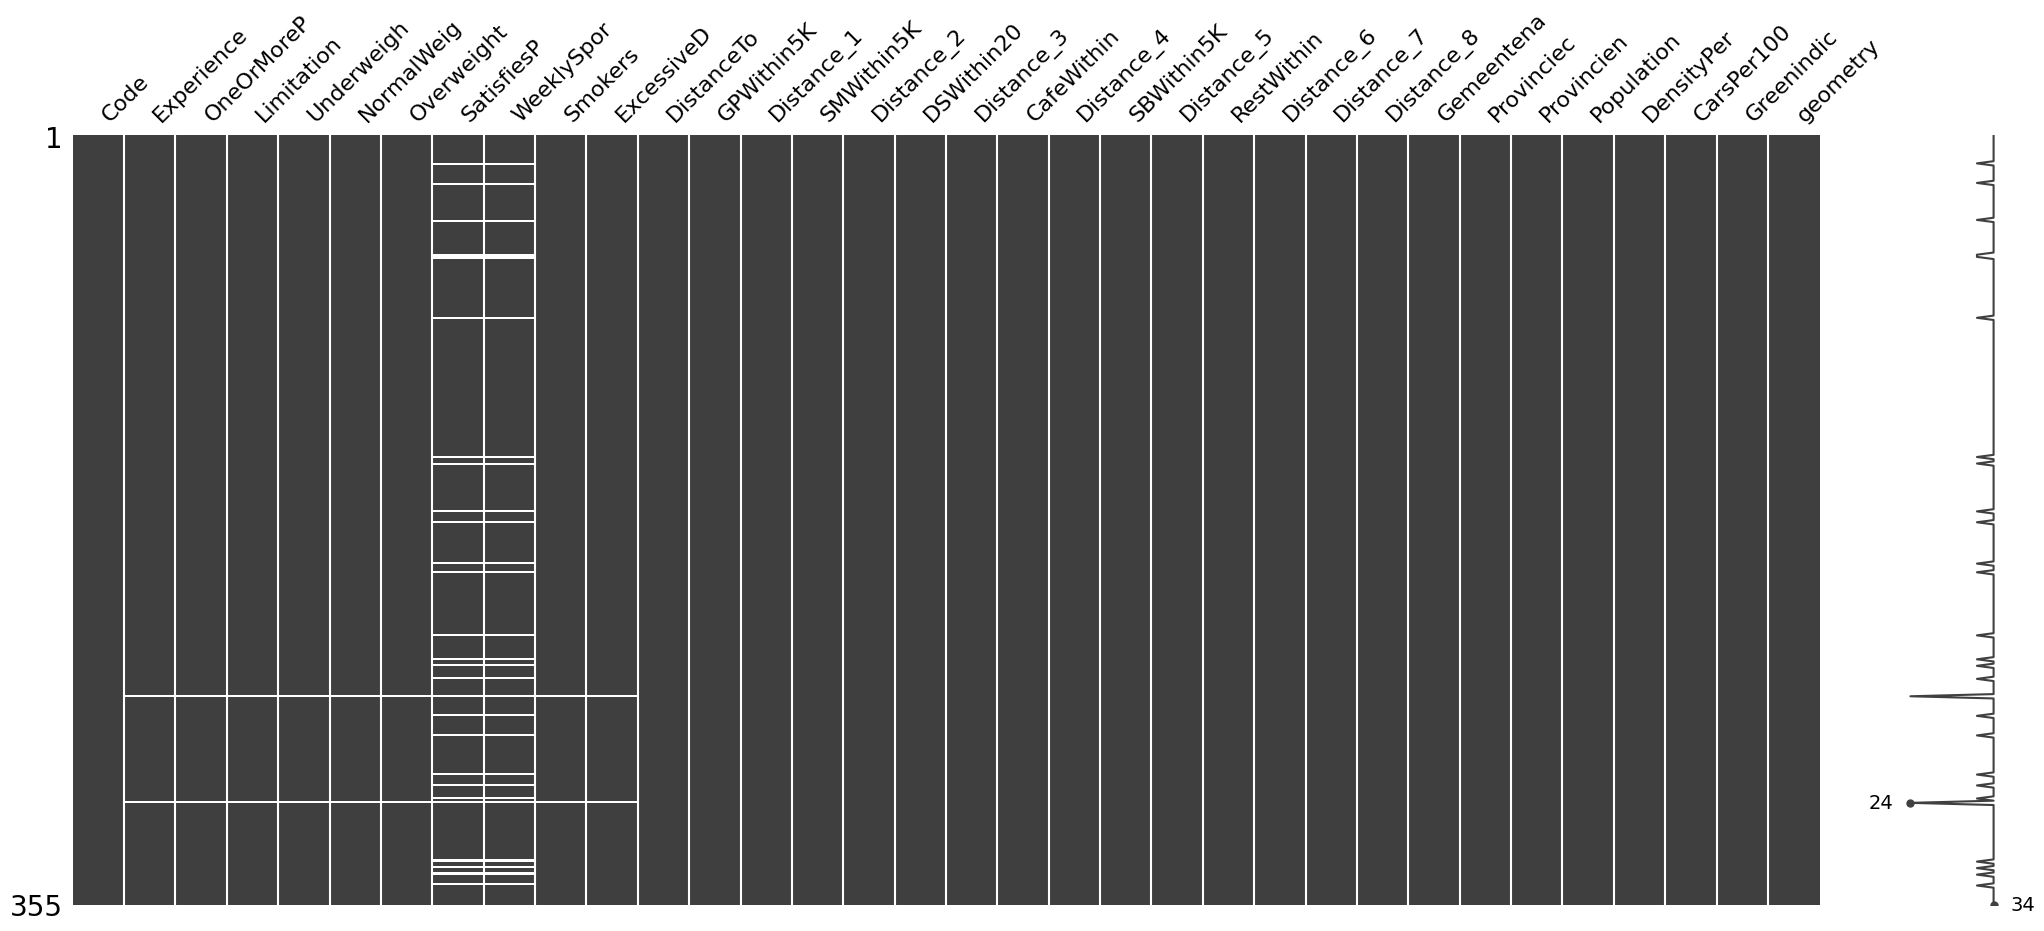

In [7]:
# Visualize the missingness of the data
msno.matrix(gdf)

In [8]:
# Calculate the number of missing values in each row
missing_values_per_row = gdf.isnull().sum(axis=1)

# Set a threshold to filter rows with a high number of missing values
threshold = len(gdf.columns) - 30

# Extract the 'code' values for rows with a high number of missing values
rows_with_missing_values = missing_values_per_row[missing_values_per_row >= threshold]
codes_with_missing_values = gdf.loc[rows_with_missing_values.index, 'Code']

# Display the extracted codes
print(codes_with_missing_values)

# These are islands which we will omit from the analysis

258    GM0088
307    GM0096
Name: Code, dtype: object


In [9]:
# Based on the plot and information above we drop the columns with high incompleteness (SatisfiesP and WeeklySpor)
# As well as the two municipalities with high incompleteness (GM0088 and GM0096)

# Drop specific rows by index
rows_to_drop = [258, 307]
gdf = gdf.drop(rows_to_drop, axis=0)

# Drop specific columns
columns_to_drop = ['SatisfiesP', 'WeeklySpor']
gdf = gdf.drop(columns_to_drop, axis=1)

# Reset index after dropping rows (optional)
gdf = gdf.reset_index(drop=True)

gdf.shape

,Code,Experience,OneOrMoreP,Limitation,Underweigh,NormalWeig,Overweight,Smokers,ExcessiveD,DistanceTo,...,Distance_7,Distance_8,Gemeentena,Provinciec,Provincien,Population,DensityPer,CarsPer100,Greenindic,geometry
0,GM1680,83.1,13.8,8.2,0.7,50.1,49.2,14.3,5.4,2.4,...,12.5,28.6,Aa en Hunze,PV22,Drenthe,25445.0,92.0,576.0,41.0,"POLYGON ((248579.512 567922.543, 248630.962 56..."
1,GM0358,82.7,10.2,5.8,1.2,50.3,48.5,13.0,5.0,0.9,...,8.1,8.9,Aalsmeer,PV27,Noord-Holland,31859.0,1584.0,532.0,50.0,"POLYGON ((116307.661 478635.954, 116369.516 47..."
2,GM0197,79.1,15.1,8.3,1.4,49.2,49.4,14.7,6.6,1.5,...,4.4,41.0,Aalten,PV25,Gelderland,27121.0,281.0,527.0,39.0,"POLYGON ((236230.546 443306.852, 236251.256 44..."
3,GM0059,79.1,16.0,11.4,0.8,42.6,56.6,19.8,7.9,1.6,...,7.3,26.8,Achtkarspelen,PV21,Friesland,27843.0,272.0,529.0,46.0,"POLYGON ((208871.810 587327.160, 208892.310 58..."
4,GM0482,77.0,17.1,11.5,2.0,41.7,56.3,14.9,5.2,0.8,...,8.5,11.2,Alblasserdam,PV28,Zuid-Holland,20165.0,2297.0,454.0,68.0,"POLYGON ((102779.950 432792.060, 102785.681 43..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,GM0879,78.6,13.9,8.1,0.8,44.4,54.8,12.2,8.5,2.2,...,12.9,15.5,Zundert,PV30,Noord-Brabant,21829.0,181.0,569.0,34.0,"POLYGON ((108753.234 394902.697, 108820.795 39..."
349,GM0301,79.6,14.0,9.0,1.7,50.6,47.7,16.8,5.0,0.8,...,2.6,2.6,Zutphen,PV25,Gelderland,47934.0,1170.0,446.0,58.0,"POLYGON ((210514.008 464180.421, 210524.205 46..."
350,GM1896,83.0,12.2,7.8,1.9,42.5,55.6,18.2,7.6,1.0,...,11.4,15.3,Zwartewaterland,PV23,Overijssel,22685.0,275.0,493.0,68.0,"MULTIPOLYGON (((197752.503 517522.481, 197831...."
351,GM0642,75.2,15.0,10.2,2.1,41.2,56.7,14.9,5.6,0.7,...,2.0,5.4,Zwijndrecht,PV28,Zuid-Holland,44737.0,2204.0,480.0,53.0,"POLYGON ((100667.470 428125.890, 100687.210 42..."


<AxesSubplot: >

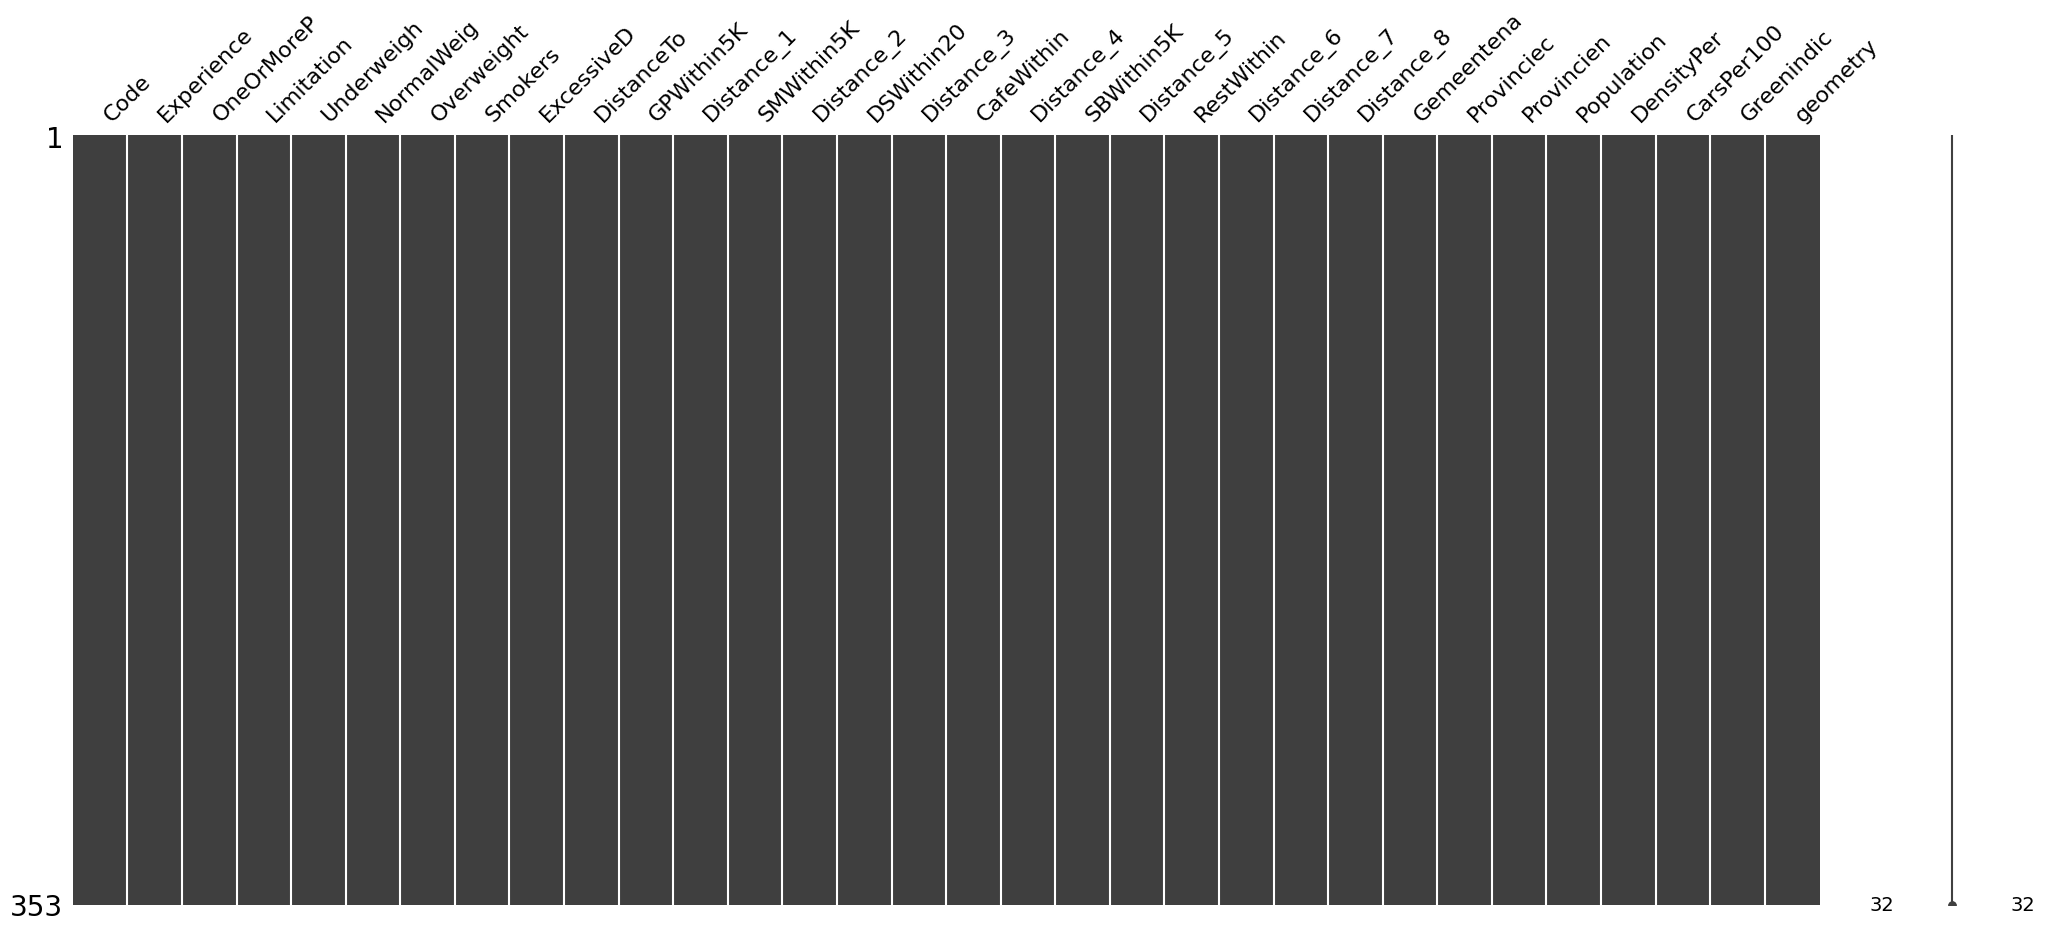

In [10]:
# Visualize the missingness of the data
msno.matrix(gdf)

## Attribute selection (multicollinearity & VIF)

In [11]:
# Mask without overweight

gdf_mask = gdf.drop(columns=['Overweight'])

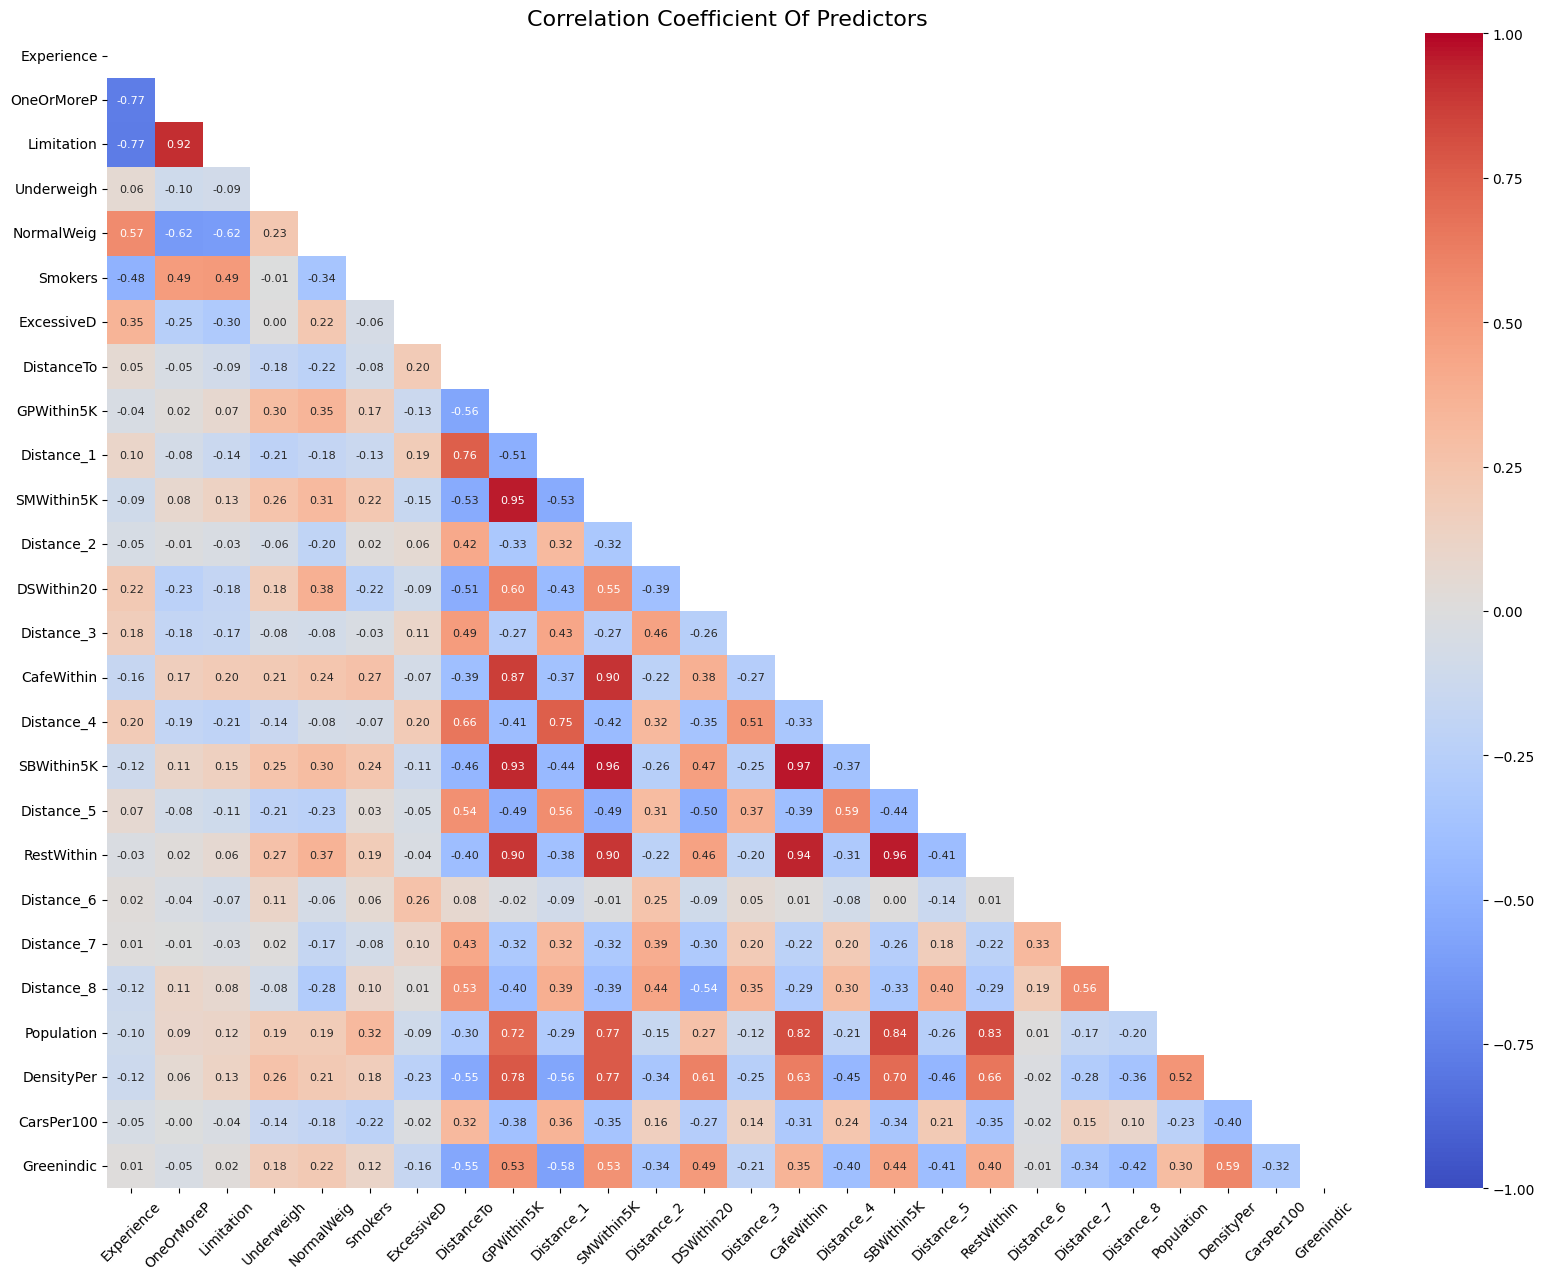

In [14]:
# Heatmap visualizations

# set figure size
plt.figure(figsize=(20, 15))

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(gdf_mask.corr(), dtype=bool))

# generate heatmap
sns.heatmap(gdf_mask.corr(), annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.title('Correlation Coefficient Of Predictors', fontsize=16)
plt.show()

In [15]:
# Get correlation matrix
corr_matrix = gdf_mask.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.7:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
SBWithin5K
Limitation
Distance_4
RestWithin
Experience
DensityPer
GPWithin5K
OneOrMoreP
SMWithin5K
CafeWithin
Population
DistanceTo
Distance_1


In [16]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    X = gdf_mask[considered_features].copy()  # create a copy of the DataFrame
    X = X.dropna()  # drop any rows with missing values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infinities with NaNs
    X.dropna(inplace=True)  # drop any rows with NaNs (due to infinities)
    
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i), 1) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [17]:
# features to consider removing
considered_features = high_correlation_features

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
0,SBWithin5K,66.3
8,SMWithin5K,25.9
9,CafeWithin,19.7
3,RestWithin,17.4
6,GPWithin5K,16.5
7,OneOrMoreP,7.4
1,Limitation,7.2
10,Population,4.0
12,Distance_1,3.7
5,DensityPer,3.1


In [18]:
# compute vif values after removing a feature
considered_features.remove('SBWithin5K')
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
7,SMWithin5K,17.1
5,GPWithin5K,16.0
2,RestWithin,14.0
8,CafeWithin,13.6
6,OneOrMoreP,7.4
0,Limitation,7.2
9,Population,3.7
11,Distance_1,3.6
4,DensityPer,3.1
10,DistanceTo,2.9


In [19]:
# compute vif values after removing a feature
considered_features.remove('SMWithin5K')
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
2,RestWithin,13.9
7,CafeWithin,12.3
5,GPWithin5K,9.4
6,OneOrMoreP,7.4
0,Limitation,7.2
8,Population,3.5
10,Distance_1,3.4
4,DensityPer,2.9
9,DistanceTo,2.8
3,Experience,2.7


In [20]:
# compute vif values after removing a feature
considered_features.remove('RestWithin')
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
4,GPWithin5K,8.3
6,CafeWithin,7.4
5,OneOrMoreP,7.3
0,Limitation,7.2
9,Distance_1,3.4
7,Population,3.1
3,DensityPer,2.9
8,DistanceTo,2.8
2,Experience,2.7
1,Distance_4,2.6


In [21]:
# compute vif values after removing a feature
considered_features.remove('GPWithin5K')
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
0,Limitation,7.2
4,OneOrMoreP,7.2
5,CafeWithin,3.9
8,Distance_1,3.4
6,Population,3.1
2,Experience,2.7
1,Distance_4,2.6
7,DistanceTo,2.6
3,DensityPer,2.2


In [22]:
# compute vif values after removing a feature
considered_features.remove('Limitation')
compute_vif(considered_features).sort_values('VIF', ascending=False)

# No attributes with a VIF under 5. We can continue with the remaining attributes.

,Variable,VIF
4,CafeWithin,3.9
7,Distance_1,3.4
5,Population,3.1
0,Distance_4,2.6
3,OneOrMoreP,2.6
6,DistanceTo,2.6
1,Experience,2.5
2,DensityPer,2.2


In [23]:
# Inspect the dataframe
gdf

,Code,Experience,OneOrMoreP,Limitation,Underweigh,NormalWeig,Overweight,Smokers,ExcessiveD,DistanceTo,...,Distance_7,Distance_8,Gemeentena,Provinciec,Provincien,Population,DensityPer,CarsPer100,Greenindic,geometry
0,GM1680,83.1,13.8,8.2,0.7,50.1,49.2,14.3,5.4,2.4,...,12.5,28.6,Aa en Hunze,PV22,Drenthe,25445.0,92.0,576.0,41.0,"POLYGON ((248579.512 567922.543, 248630.962 56..."
1,GM0358,82.7,10.2,5.8,1.2,50.3,48.5,13.0,5.0,0.9,...,8.1,8.9,Aalsmeer,PV27,Noord-Holland,31859.0,1584.0,532.0,50.0,"POLYGON ((116307.661 478635.954, 116369.516 47..."
2,GM0197,79.1,15.1,8.3,1.4,49.2,49.4,14.7,6.6,1.5,...,4.4,41.0,Aalten,PV25,Gelderland,27121.0,281.0,527.0,39.0,"POLYGON ((236230.546 443306.852, 236251.256 44..."
3,GM0059,79.1,16.0,11.4,0.8,42.6,56.6,19.8,7.9,1.6,...,7.3,26.8,Achtkarspelen,PV21,Friesland,27843.0,272.0,529.0,46.0,"POLYGON ((208871.810 587327.160, 208892.310 58..."
4,GM0482,77.0,17.1,11.5,2.0,41.7,56.3,14.9,5.2,0.8,...,8.5,11.2,Alblasserdam,PV28,Zuid-Holland,20165.0,2297.0,454.0,68.0,"POLYGON ((102779.950 432792.060, 102785.681 43..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,GM0879,78.6,13.9,8.1,0.8,44.4,54.8,12.2,8.5,2.2,...,12.9,15.5,Zundert,PV30,Noord-Brabant,21829.0,181.0,569.0,34.0,"POLYGON ((108753.234 394902.697, 108820.795 39..."
349,GM0301,79.6,14.0,9.0,1.7,50.6,47.7,16.8,5.0,0.8,...,2.6,2.6,Zutphen,PV25,Gelderland,47934.0,1170.0,446.0,58.0,"POLYGON ((210514.008 464180.421, 210524.205 46..."
350,GM1896,83.0,12.2,7.8,1.9,42.5,55.6,18.2,7.6,1.0,...,11.4,15.3,Zwartewaterland,PV23,Overijssel,22685.0,275.0,493.0,68.0,"MULTIPOLYGON (((197752.503 517522.481, 197831...."
351,GM0642,75.2,15.0,10.2,2.1,41.2,56.7,14.9,5.6,0.7,...,2.0,5.4,Zwijndrecht,PV28,Zuid-Holland,44737.0,2204.0,480.0,53.0,"POLYGON ((100667.470 428125.890, 100687.210 42..."


In [24]:
# Based on the above VIF values we drop the columns SBWithin5K, SMWithin5K, 
gdf = gdf.drop(columns=['SBWithin5K', 'SMWithin5K', 'Limitation', 'GPWithin5K','RestWithin'])

In [26]:
# Inspect the shape of the data frame
gdf.shape

(353, 27)

In [25]:
# Save the file to a .shp file for geopandas and spatial analysis
gdf.to_file('gdf_model.shp')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cfc4dc78-fd2a-4b67-8dea-b0c970af57ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>